In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import math
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget -O train.csv https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Train/Monthly-train.csv
!wget -O test.csv https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Test/Monthly-test.csv

--2022-04-08 20:06:41--  https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Train/Monthly-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91655432 (87M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  87.41M  22.7MB/s    in 3.6s    

2022-04-08 20:06:45 (24.0 MB/s) - ‘train.csv’ saved [91655432/91655432]

--2022-04-08 20:06:45--  https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Test/Monthly-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 O

In [ ]:
history_length = 106
forecast_length = 24

In [ ]:
def load_data():
  train_series = pd.read_csv("train.csv")
  test_series = pd.read_csv("test.csv")
  train_series = train_series.iloc[: , 1:].values
  test_series = test_series.iloc[:,1:].values
  
  history_data = []
  forecast_data = []
  for idx,x in enumerate(train_series):
    x = np.array(x)
    x = x[~np.isnan(x)]
    min_val = min(x) *0.9
    max_val = max(x) * 1.1
    x = ((np.array(x) - min_val) / (max_val - min_val) )
    if(x.shape[0]>history_length + forecast_length):
      history_data.append(x[-(history_length + forecast_length):])
      y = test_series[idx]
      y = ((np.array(y) - min_val) / (max_val - min_val) )
      forecast_data.append(y)
  print(len(history_data))
  history_data = torch.tensor(history_data)
  forecast_data = torch.tensor(forecast_data)
  return history_data,forecast_data

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
history_data,forecast_data = load_data()

32133


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


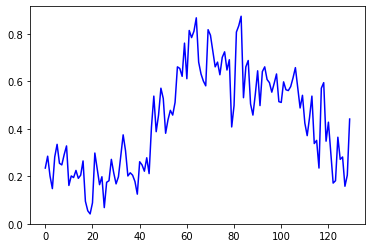

In [ ]:
idx = 1
plt.plot(np.arange(history_length+forecast_length), history_data[idx],color = 'b')
# plt.plot(np.arange(history_length+forecast_length,history_length+2*forecast_length),forecast_data[idx],color = 'g')

In [ ]:

class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.__padding = (kernel_size - 1) * dilation
        
    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))


class context_embedding(torch.nn.Module):
    def __init__(self,in_channels=1,embedding_size=256,k=5):
        super(context_embedding,self).__init__()
        self.causal_convolution = CausalConv1d(in_channels,embedding_size,kernel_size=k)

    def forward(self,x):
        x = self.causal_convolution(x)
        return torch.tanh(x)


In [ ]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = context_embedding(2,256,9)
        self.positional_embedding = torch.nn.Embedding(512,256)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=256,nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3)
        
        self.fc1 = torch.nn.Linear(256,1)
        
    def forward(self,x,y,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)

        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        z_embedding = self.input_embedding(z).permute(2,0,1)
        
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)
        
        input_embedding = z_embedding+positional_embeddings
        
        transformer_embedding = self.transformer_decoder(input_embedding,attention_masks)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        
        return output


In [ ]:
#!/usr/bin/env python
# coding: utf-8


import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
    
class time_series_decoder_paper(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=history_length,istraining = True,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = history_length
        self.N = len(history_data)
        self.transform = None
        self.train_idx = int(0.8*(len(history_data)))
        self.train_len = self.train_idx + 1
        self.test_len = self.N - self.train_len
        self.x = torch.cat(self.N*[torch.arange(0,history_length+forecast_length).type(torch.float).unsqueeze(0)])
        self.fx = history_data[0:self.N,0:history_length+forecast_length].type(torch.FloatTensor)
        self.masks = self._generate_square_subsequent_mask(t0)
        self.istraining = istraining
                
        
        # print out shapes to confirm desired output
        print("x: {}*{}".format(*list(self.x.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)))        
        
    def __len__(self):
        if self.istraining:
          return self.train_len
        return self.test_len
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if not self.istraining:
          idx = idx + self.train_idx
          


        sample = (self.x[idx,:],
                  self.fx[idx,:],
                  self.masks)

        if self.transform:
            sample=self.transform(sample)
            
        return sample
    
    def _generate_square_subsequent_mask(self,t0):
        mask = torch.zeros(t0+forecast_length,t0+forecast_length)
        for i in range(0,t0):
            mask[i,t0:] = 1 
        for i in range(t0,t0+forecast_length):
            mask[i,i+1:] = 1
        mask = mask.float().masked_fill(mask == 1, float('-inf'))#.masked_fill(mask == 1, float(0.0))
        return mask

In [ ]:
# t0 = 24

In [ ]:
# train_dataset = Dataloader.time_series_decoder_missing_paper(t0,4500) # missing
# validation_dataset = Dataloader.time_series_decoder_missing_paper(t0,500) # missing 
# test_dataset = Dataloader.time_series_decoder_missing_paper(t0,1000) # missing
# t0 = data.shape[1] - 24
train_dataset = time_series_decoder_paper(istraining = True)
test_dataset = time_series_decoder_paper(istraining = False)

x: 32133*130 fx: 32133*130
x: 32133*130 fx: 32133*130


In [ ]:
len(test_dataset) / 128

50.203125

In [ ]:
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dl = DataLoader(test_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def Dp(y_pred,y_true,q):
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])


In [ ]:
def Rp_num_den(y_preds,y_trues,q):
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator


In [ ]:
model = TransformerTimeSeries().to(device)
lr = .0005 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss()

In [ ]:
def train_epoch(model,train_dl,t0=96):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,y,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
        loss = criterion(output.squeeze()[:,(history_length-1):(history_length+forecast_length-1)],y.cuda()[:,history_length:]) # not missing data
        # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n


In [ ]:
def eval_epoch(model,validation_dl,t0=96):
    model.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            loss = criterion(output.squeeze()[:,(history_length-1):(history_length+forecast_length-1)],y.cuda()[:,history_length:]) # not missing data
            # loss = criterion(output.squeeze()[:,(t0-1-10):(t0+24-1-10)],y.cuda()[:,(t0-10):]) # missing data
            
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]
            
    return eval_loss/n

In [ ]:
def test_epoch(model,test_dl,t0=96):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            for p,o in zip(output.squeeze()[:,(history_length-1):(history_length+forecast_length-1)].cpu().numpy().tolist(),y.cuda()[:,t0:].cpu().numpy().tolist()): # not missing data
            #for p,o in zip(output.squeeze()[:,(t0-1-10):(t0+24-1-10)].cpu().numpy().tolist(),y.cuda()[:,(t0-10):].cpu().numpy().tolist()): # missing data


                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
        
    return Rp


In [ ]:
train_epoch_loss = []
eval_epoch_loss = []
Rp_best = 10
epochs = 40
Rp = 0
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []
    
    l_t = train_epoch(model,train_dl,history_length)
    train_loss.append(l_t)
    
    l_e = eval_epoch(model,validation_dl,history_length)
    eval_loss.append(l_e)
    
    Rp = test_epoch(model,test_dl,history_length)

    if Rp_best > Rp:
        Rp_best = Rp
        
    train_epoch_loss.append(np.mean(train_loss))
    eval_epoch_loss.append(np.mean(eval_loss))
    
    print("Epoch {}: Train loss: {} \t Validation loss: {} \t R_p={}".format(e,
                                                             np.mean(train_loss),
                                                             np.mean(eval_loss),Rp))

Epoch 0: Train loss: 0.007958795439519897 	 Validation loss: 0.008880936008478914 	 R_p=0.10742151428517198
Epoch 1: Train loss: 0.0073815518013080035 	 Validation loss: 0.007809784189747792 	 R_p=0.10780684033841598
Epoch 2: Train loss: 0.006959535884733045 	 Validation loss: 0.011080353848643107 	 R_p=0.14455077443543654
Epoch 3: Train loss: 0.0066480816866849365 	 Validation loss: 0.008300167289868326 	 R_p=0.11729079398519088
Epoch 4: Train loss: 0.006467507935354845 	 Validation loss: 0.006068356831694573 	 R_p=0.08701550315714111
Epoch 5: Train loss: 0.0061416393700575115 	 Validation loss: 0.006423159421865364 	 R_p=0.09391981416157529
Epoch 6: Train loss: 0.005947634466638764 	 Validation loss: 0.00786982007629629 	 R_p=0.11324729957019733
Epoch 7: Train loss: 0.005698956058074033 	 Validation loss: 0.006485757264205731 	 R_p=0.0956941461571126
Epoch 8: Train loss: 0.0056708815141086515 	 Validation loss: 0.005088077130394999 	 R_p=0.07342793065400427
Epoch 9: Train loss: 0.005

In [ ]:
print("Rp best={}".format(Rp_best))

Rp best=0.06799731897636536


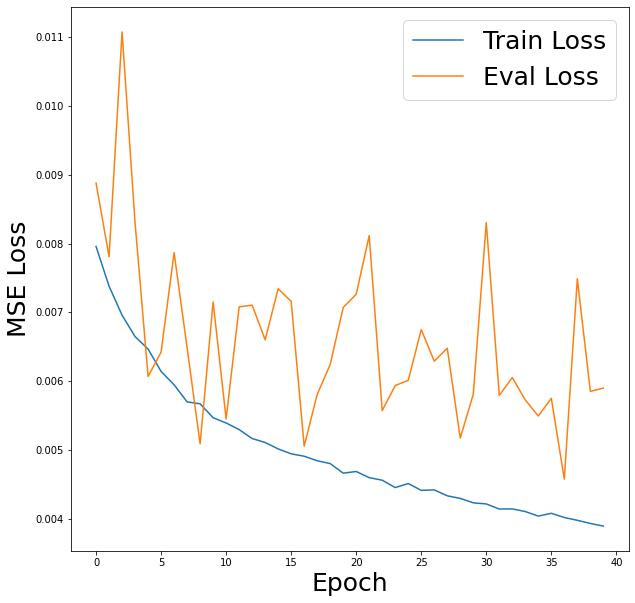

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.plot(eval_epoch_loss)
plt.legend(['Train Loss','Eval Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.show()


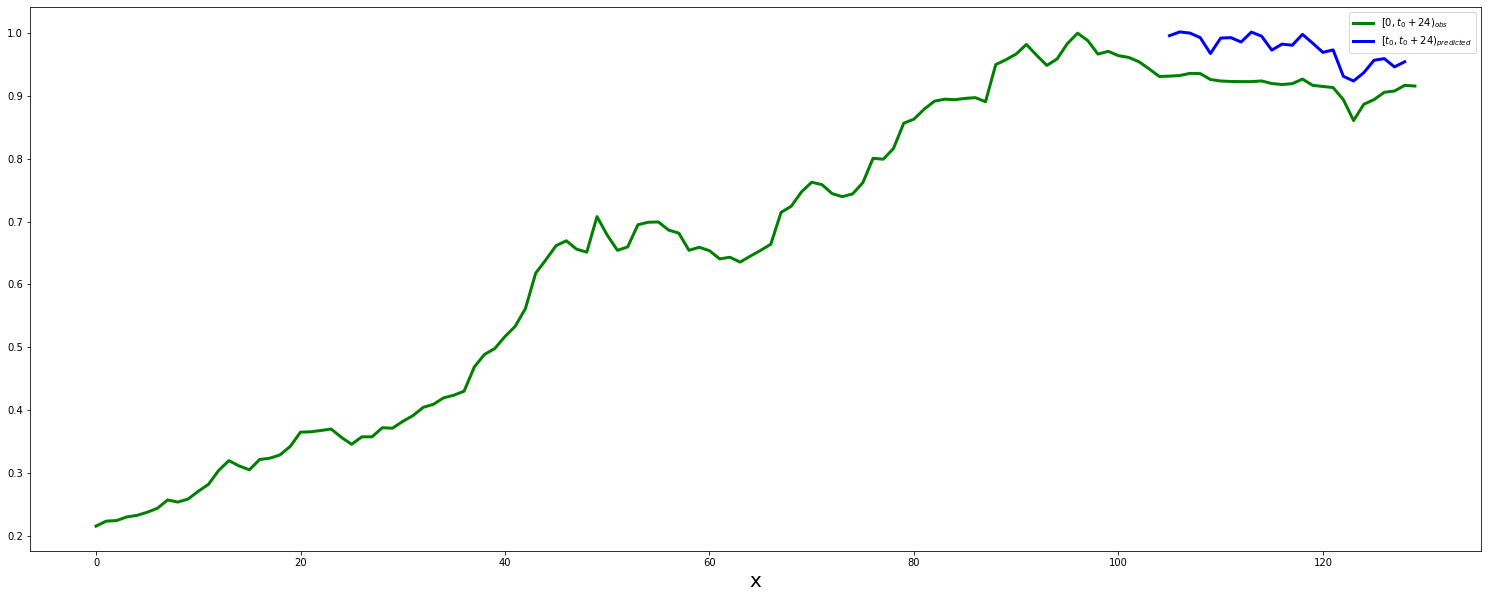

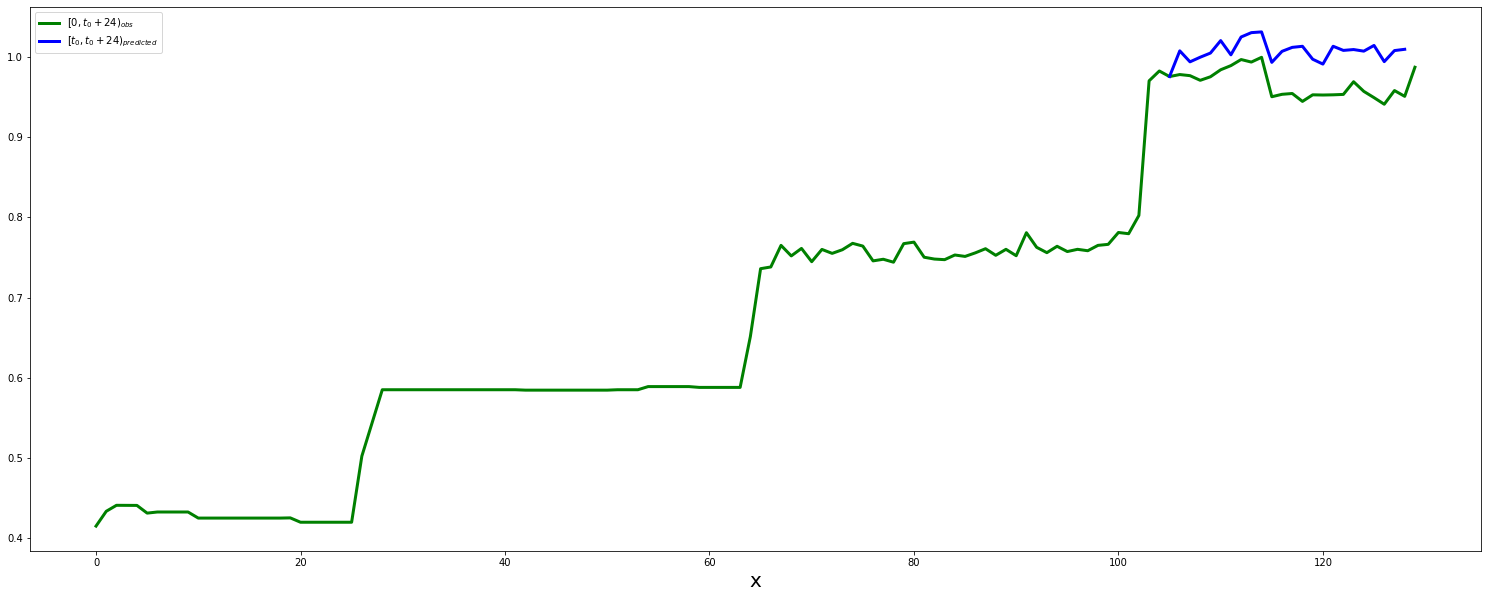

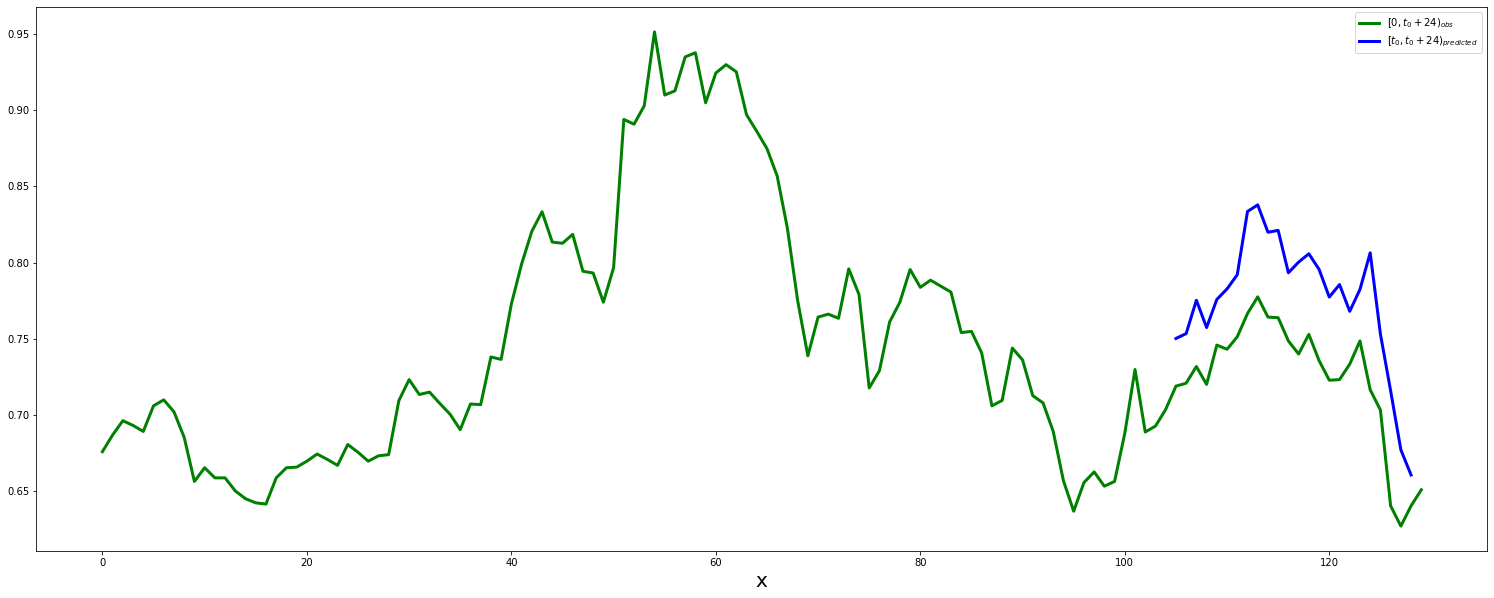

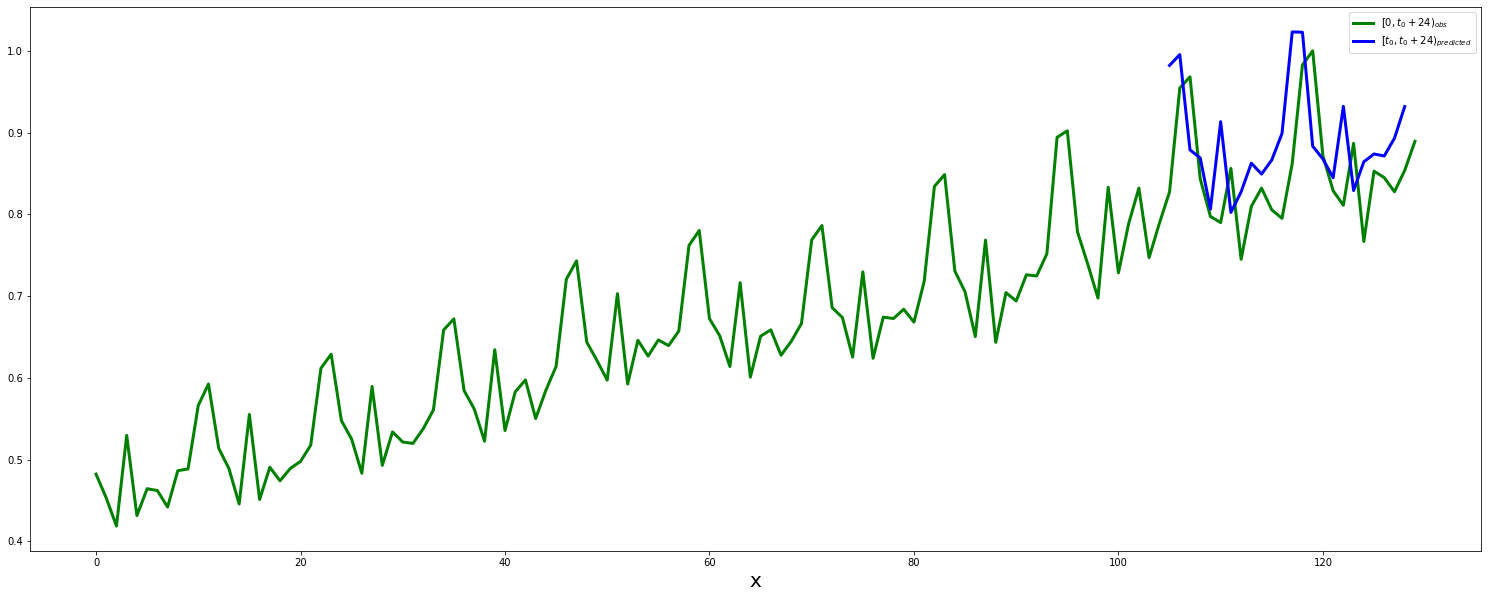

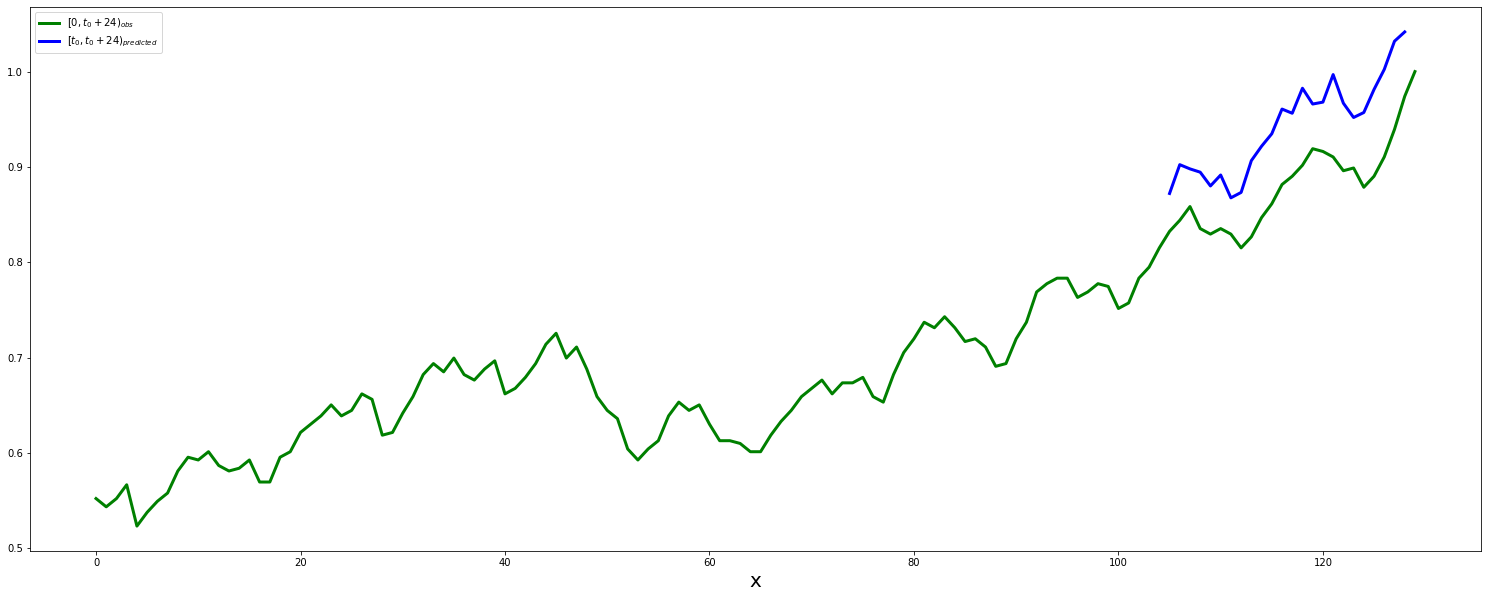

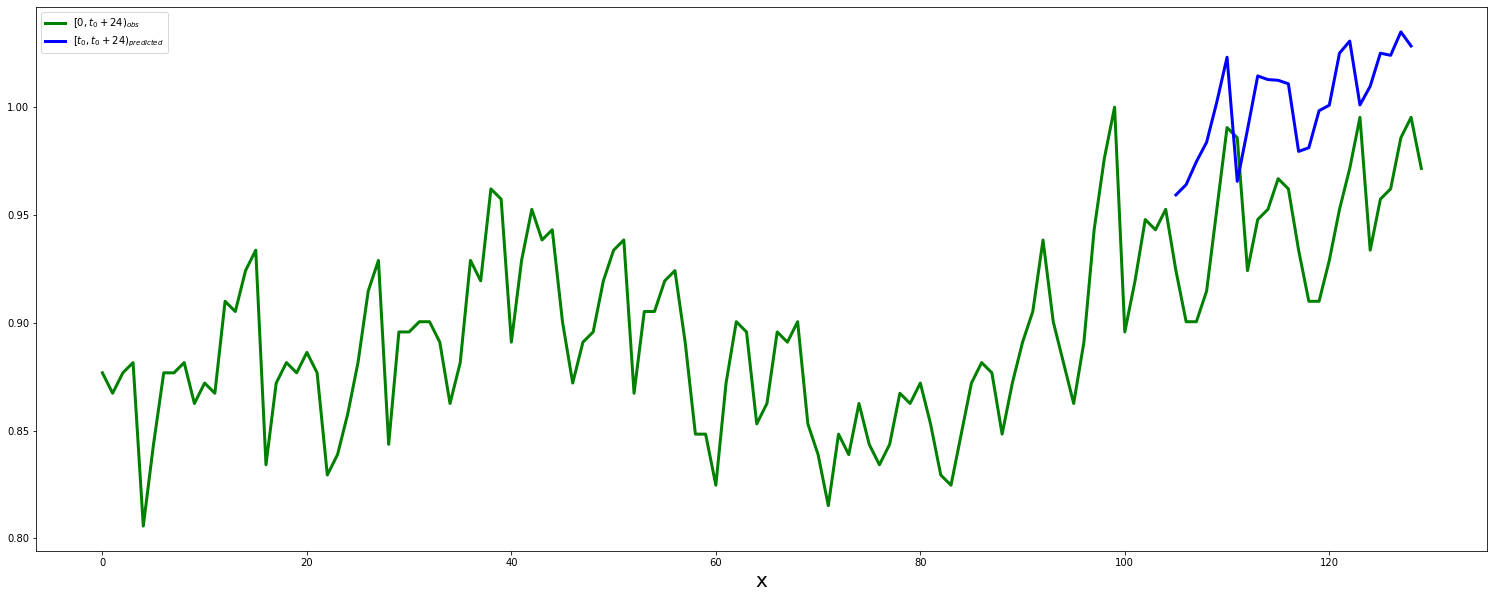

In [ ]:
n_plots = 5
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            # print(output.shape)
            # print(output[0,(t0-1):(t0+24-1)].shape)

            if step > n_plots:
                break

            with torch.no_grad():
                plt.figure(figsize=(26,10))
                plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'g',linewidth=3)
                plt.plot(x[0,history_length-1:(history_length+forecast_length-1)].cpu().detach().squeeze().numpy(),
                         output[0,(history_length-1):(history_length+forecast_length-1)].cpu().detach().squeeze().numpy(),'b',linewidth=3) # not missing data
                # plt.plot(x[0,(t0-10):(t0+24-10)].cpu().detach().squeeze().numpy(),output[0,(t0-1-10):(t0+24-1-10)].cpu().detach().squeeze().numpy(),'b--',linewidth=3) # missing data
                plt.xlabel("x",fontsize=20)
                plt.legend(["$[0,t_0+24)_{obs}$","$[t_0,t_0+24)_{predicted}$"])


In [ ]:
 def get_attn(model,x,y,attention_masks):
    model.eval()
    with torch.no_grad():
        x=x.cuda(); y=y.cuda(); attention_masks = attention_masks.cuda()
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)
        z_embedding = model.input_embedding(z).permute(2,0,1)
        positional_embeddings = model.positional_embedding(x.type(torch.long)).permute(1,0,2)
        input_embedding = z_embedding+positional_embeddings
                
        attn_layer_i = []
        for layer in model.transformer_decoder.layers:
            attn_layer_i.append(layer.self_attn(input_embedding,input_embedding,input_embedding,attn_mask=attention_masks)[-1].squeeze().cpu().detach().numpy())
            input_embedding = layer.forward(input_embedding,attention_masks)
        
        return attn_layer_i


In [ ]:
idx_example = 5
attn_layers = get_attn(model,test_dataset[idx_example][0].unsqueeze(0),test_dataset[idx_example][1].unsqueeze(0),test_dataset[idx_example][2])


In [ ]:
# plt.figure(figsize=(10,5))
# plt.plot(test_dataset[idx_example][0].numpy(),train_dataset[10][1].numpy())
# plt.plot([t0+24-1,t0+24-1],[20,120],'g--') # not missing data
# # plt.plot([t0+24-1,t0+24-1],[20,120],'g--') # missing data
# plt.figure(figsize=(10,10))
# plt.plot(attn_layers[0][t0+24-1]) # not missing data
# plt.plot(attn_layers[1][t0+24-1]) # not missing data
# plt.plot(attn_layers[2][t0+24-1]) # not missing data

# #plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[0][119-10]) # missing data
# #plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[1][119-10]) # missing data
# #plt.plot(train_dataset[idx_example][0].numpy(),attn_layers[2][119-10]) # missing data



# plt.legend(["attn score in layer 1","attn score in layer 2","attn score in layer 3"])
# plt.title("Attn for t = 119") # not missing data

# plt.show()


In [ ]:
def smape(act,forc):
    return 100/len(act) * np.sum(2 * np.abs(forc - act) / (np.abs(act) + np.abs(forc)))

In [ ]:
def find_smape(model):
  smapes = []
  with torch.no_grad():
      model.eval()
      for step,(x,y,attention_masks) in enumerate(test_dl):
              output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
              actual = y[0,(history_length-1):(history_length+24-1)].cpu().detach().squeeze().numpy()
              forecast = output[0,(history_length-1):(history_length+24-1)].cpu().detach().squeeze().numpy()
              smapes.append(smape(actual,forecast))
      
      print(len(smapes))
      return np.mean(smapes)

In [ ]:
find_smape(model)

51


12.844672847807018

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/TimeSeriesModels/nologsparse/model_save_v2.pth")